# Dimensional reduction of bispidine leu LL form
## Data from westpa simulations
### Date: 30-Aug-2022

# Vampnets with ELU activations and softmax at last layer

## Load packages

In [84]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyemma
import deeptime as dt
import torch
import torch.nn as nn
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader
from deeptime.util.torch import MLP

## Set torch device

In [85]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")
torch.set_num_threads(8)

print(f"Using device {device}")

Using device cpu


## Load relevant data

In [86]:
topology = '../run2/topology_cgenff/lll_ini.pdb'
data = np.load('data.npy')[:,:,:62]
#data = np.concatenate(data)[-100000:,:] # take only equilibrated data
data = np.concatenate(data)
di1 = 10
di2 = 18
pc_data = np.stack([data[:,di1],data[:,di2]], axis =1) #progress coordinate data

## Visalize trajectory density in PC space

Text(0.5, 1.0, 'Density from all WE runs')

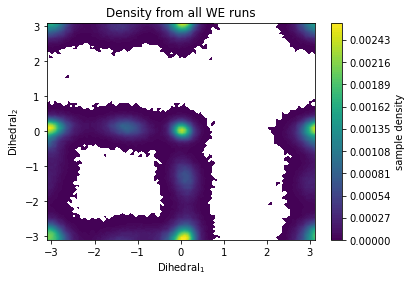

In [87]:
pyemma.plots.plot_density(*pc_data.T)
plt.xlabel(r'Dihedral$_1$')
plt.ylabel(r'Dihedral$_2$')
plt.title('Density from all WE runs')

## Define neural network architecture for concatenated set

In [89]:
tau = 1
batch_size = 5000
val_ratio = 0.15
network_depth = 8
layer_width = 40
learning_rate = 5e-4
output_size = 8
nodes = [data.shape[1]] + [layer_width for _ in range(network_depth)] + [output_size]
nb_epoch = 50

dataset = dt.util.data.TrajectoryDataset(lagtime=tau, trajectory=data.astype(np.float32))
n_val = int(len(dataset)*val_ratio)
train_data, val_data = torch.utils.data.random_split(dataset, [len(dataset)-n_val, n_val])

lobe = MLP(units=nodes, nonlinearity=nn.ELU, output_nonlinearity=nn.Softmax)
vampnet = dt.decomposition.deep.VAMPNet(lobe=lobe, learning_rate=learning_rate)

loader_train = DataLoader(train_data, batch_size = batch_size, shuffle=True)
loader_val = DataLoader(val_data, batch_size=len(val_data), shuffle=False)
print('Ready to train')
model = vampnet.fit(data_loader=loader_train, n_epochs=nb_epoch, validation_loader=loader_val, progress=tqdm).fetch_model()

Ready to train


VAMPNet epoch:   0%|          | 0/50 [00:00<?, ?it/s]

### Visualize losses (training and validation)

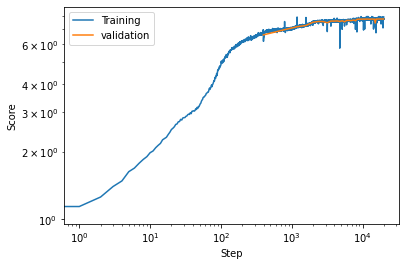

In [90]:
plt.loglog(*vampnet.train_scores.T, label='Training')
plt.loglog(*vampnet.validation_scores.T, label='validation')
plt.xlabel('Step')
plt.ylabel('Score')
plt.legend();

### Evaluate Model

In [91]:
state_probabilities = model.transform(data)

/opt/anaconda3/lib/python3.9/site-packages/torch/nn/modules/container.py:141: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


In [92]:
tau=1
vamp_score = dt.decomposition.vamp_score_data(state_probabilities[:-int(tau),:],state_probabilities[int(tau):,:])
print(f"The VAMP score is: {vamp_score}")

The VAMP score is: 7.7945818844487


### Transform data and see clusters

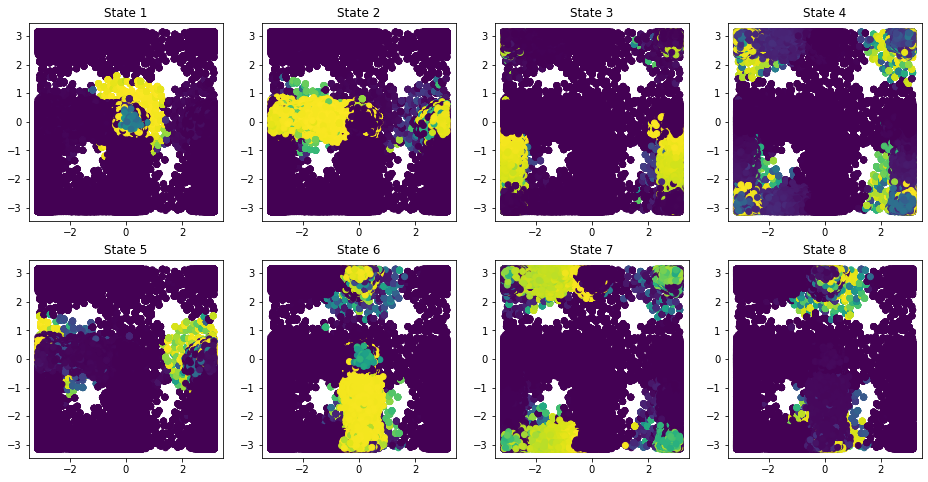

In [93]:
f, axes = plt.subplots(2, 4, figsize=(16, 8))
for i, ax in enumerate(axes.flatten()):
    ax.scatter(*pc_data.T, c=state_probabilities[..., i])
    ax.set_title(f'State {i+1}')

In [94]:
for ix, (mini, maxi) in enumerate(zip(np.min(state_probabilities, axis=0), 
                                      np.max(state_probabilities, axis=0))):
    print(f"State {ix+1}: [{mini}, {maxi}]")

State 1: [2.6757413992828383e-11, 0.9950998425483704]
State 2: [7.159166315329202e-11, 0.996010422706604]
State 3: [1.4416838382824704e-11, 0.9921878576278687]
State 4: [3.569996728791658e-11, 0.9920799136161804]
State 5: [6.709000108934271e-12, 0.9969050288200378]
State 6: [1.8092487508170052e-09, 0.9948040843009949]
State 7: [3.994672370666308e-10, 0.9875195026397705]
State 8: [4.103161213575568e-11, 0.9751119017601013]


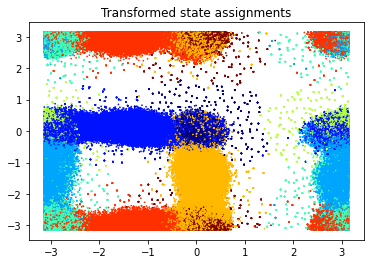

In [95]:
assignments = state_probabilities.argmax(1)
plt.scatter(*pc_data.T, c=assignments, s=.5, cmap='jet')
plt.title('Transformed state assignments');

## Find correlations with the dihedral feature space
Cannot calcluate with softmax, use ReLU

In [96]:
import pickle
with open('vnet_softmax_full_o8-t1.pkl', 'wb') as file:
    pickle.dump(model, file)

# VAMPNet with ReLU activations at all layers
* See this [deeptime tutorial](https://deeptime-ml.github.io/latest/notebooks/vampnets.html)
* Also see [this](https://deeptime-ml.github.io/latest/notebooks/examples/sqrt-model-dimrx.html)

## Load packages

In [82]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pyemma
import deeptime as dt
import torch
import torch.nn as nn
from tqdm.notebook import tqdm
from torch.utils.data import DataLoader
from deeptime.util.torch import MLP

### Set torch device

In [83]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    torch.backends.cudnn.benchmark = True
else:
    device = torch.device("cpu")
torch.set_num_threads(8)

print(f"Using device {device}")

Using device cpu


## Load relevant data

In [3]:
topology = '../run2/topology_cgenff/lll_ini.pdb'
data = np.load('data.npy')[:,:,:62]
data = np.concatenate(data)
#data = np.concatenate(data)[-100000:,:] # take only equilibrated data
di1 = 10
di2 = 18
pc_data = np.stack([data[:,di1],data[:,di2]], axis =1) #progress coordinate data

### Visualize trajectory density in PC space

Text(0.5, 1.0, 'Density from all WE runs')

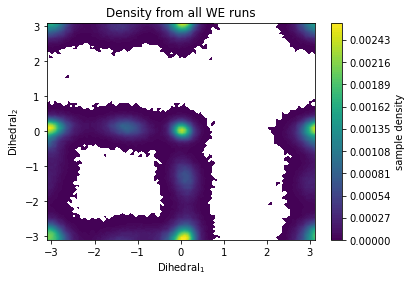

In [4]:
pyemma.plots.plot_density(*pc_data.T)
plt.xlabel(r'Dihedral$_1$')
plt.ylabel(r'Dihedral$_2$')
plt.title('Density from all WE runs')

## Define neural network architecture for concatenated set

In [5]:
tau = 1
batch_size = 5000
val_ratio = 0.15
network_depth = 8
layer_width = 40
learning_rate = 5e-4
output_size = 8
nodes = [data.shape[1]] + [layer_width for _ in range(network_depth)] + [output_size]
nb_epoch = 100

dataset = dt.util.data.TrajectoryDataset(lagtime=tau, trajectory=data.astype(np.float32))
n_val = int(len(dataset)*val_ratio)
train_data, val_data = torch.utils.data.random_split(dataset, [len(dataset)-n_val, n_val])

lobe = MLP(units=nodes, nonlinearity=nn.ReLU)
vampnet = dt.decomposition.deep.VAMPNet(lobe=lobe, learning_rate=learning_rate)

loader_train = DataLoader(train_data, batch_size = batch_size, shuffle=True)
loader_val = DataLoader(val_data, batch_size=len(val_data), shuffle=False)
print('Ready to train')
model = vampnet.fit(data_loader=loader_train, n_epochs=nb_epoch, validation_loader=loader_val, progress=tqdm).fetch_model()

Ready to train


VAMPNet epoch:   0%|          | 0/100 [00:00<?, ?it/s]

In [6]:
import pickle
with open('vnet_relu_full_o8-t1.pkl', 'wb') as file:
    pickle.dump(model, file)

### Visualize losses (training and validation)

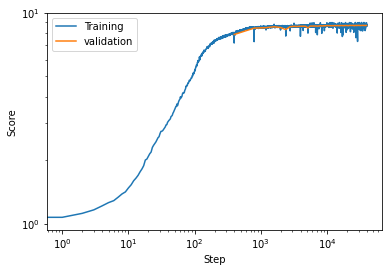

In [7]:
plt.loglog(*vampnet.train_scores.T, label='Training')
plt.loglog(*vampnet.validation_scores.T, label='validation')
plt.xlabel('Step')
plt.ylabel('Score')
plt.legend();

### Evaluate Model

In [8]:
vnet_features = model.transform(data)

In [9]:
tau=1
vamp_score = dt.decomposition.vamp_score_data(vnet_features[:-int(tau),:],vnet_features[int(tau):,:])
print(f"The VAMP score is: {vamp_score}")

The VAMP score is: 8.717993871620752


Text(0.5, 0, '# Frame')

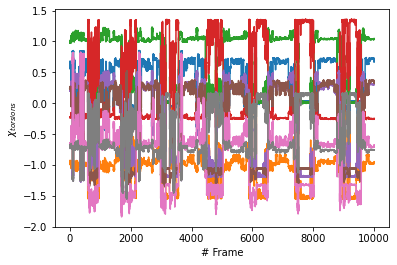

In [10]:
for i in range(0,output_size):
    plt.plot(vnet_features[:10000,i])
plt.ylabel(r'$\chi_{torsions}$')
plt.xlabel('# Frame')

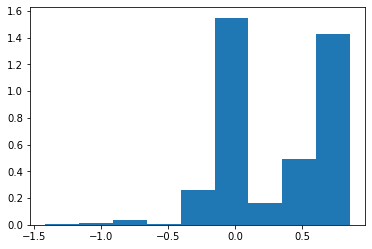

In [48]:
plt.hist(vnet_features[:10000,0],bins=9, density=True);

## Find correlations with the dihedral feature space

In [41]:
from scipy.stats import pearsonr
vnet_feature_correlation = np.zeros((data.shape[1],output_size))

for i in range(data.shape[1]):
    for j in range(output_size):
        vnet_feature_correlation[i, j] = np.abs(pearsonr(data[:, i], vnet_features[:, j])[0])

Text(0.5, 1.0, 'Pearson correlation coefficient')

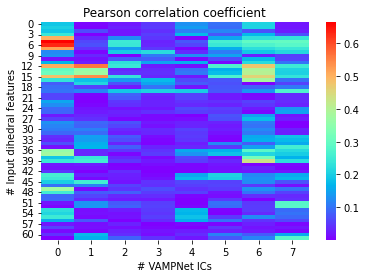

In [42]:
sns.heatmap(vnet_feature_correlation, cmap='rainbow')
plt.xlabel('# VAMPNet ICs')
plt.ylabel('# Input dihedral features')
plt.title('Pearson correlation coefficient')

## Fit to VAMP model and check scores

In [43]:
from deeptime.decomposition import VAMP

vamp_model_vnet = VAMP(lagtime=1, observable_transform=model).fit(data).fetch_model() 
vamp_model_raw = VAMP(lagtime=1, dim=8).fit(data).fetch_model()

### Plot the first dimension in both cases

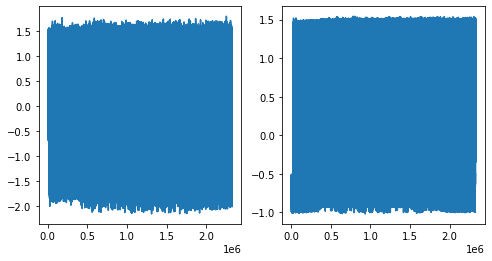

In [44]:
f, axes = plt.subplots(1,2, figsize=(8,4))
ax = axes[0]
ax.plot(vamp_model_raw.transform(data)[:,0])
ax = axes[1]
ax.plot(vamp_model_vnet.transform(data)[:,0])

### Compute the scores

In [49]:
vamp_model_raw.score(2)

5.078645638966206

In [50]:
vamp_model_vnet.score(2)

8.717993871620752

## Plot population along VAMPNet components

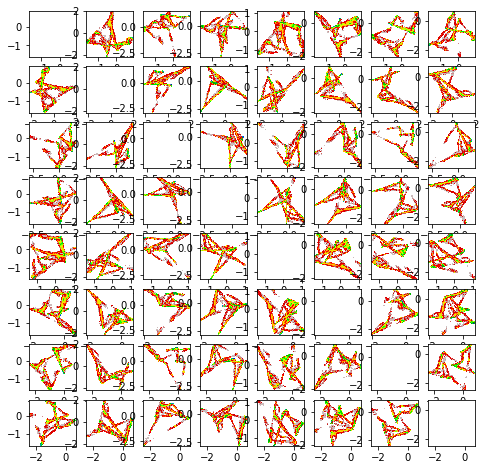

In [51]:
fig, axes = plt.subplots(8,8, figsize=(8,8))
for i in range(8):
    for j in range(8):
        pyemma.plots.plot_free_energy(vnet_features[:,i], vnet_features[:,j], ax=axes[i,j], cbar=False)

## Testing some correlations

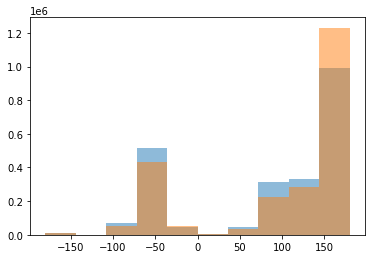

In [53]:
psi1 = data[:,15]
plt.hist(np.degrees(psi1), alpha=0.5);
psi2 = data[:,6]
plt.hist(np.degrees(psi2), alpha=0.5);

### Softmax vs ReLU correlations

In [ ]:
from scipy.stats import pearsonr
cross_feature_correlation = np.zeros((output_size,output_size))

for i in range(output_size):
    for j in range(output_size):
        cross_feature_correlation[i, j] = np.abs(pearsonr(state_probabilities[:,i], vnet_features[:, j])[0])

Text(0.5, 1.0, 'Pearson correlation coefficient')

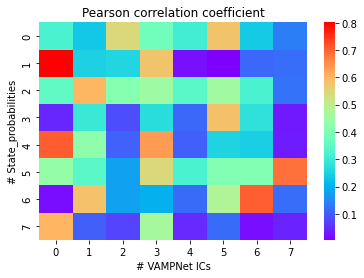

In [235]:
sns.heatmap(cross_feature_correlation, cmap='rainbow')
plt.xlabel('# VAMPNet ICs')
plt.ylabel('# State_probabilities')
plt.title('Pearson correlation coefficient')

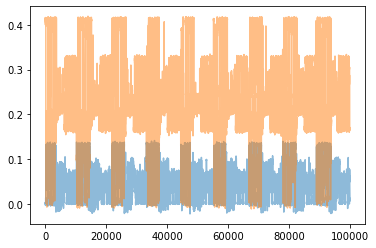

In [241]:
plt.plot(state_probabilities[:,1], alpha=0.5)
plt.plot(vnet_features[:,0], alpha=0.5)

# PCA

In [57]:
import pyemma
import deeptime
import numpy as np
import matplotlib.pyplot as plt

## Load data

In [58]:
topology = '../run2/topology_cgenff/lll_ini.pdb'
data = np.load('data.npy')[:,:,:62]
data = np.concatenate(data)
#data = np.concatenate(data)[-100000:,:] # take only equilibrated data
di1 = 10
di2 = 18
pc_data = np.stack([data[:,di1],data[:,di2]], axis =1) #progress coordinate data

(<Figure size 432x288 with 2 Axes>,
 <AxesSubplot:>,
 {'mappable': <matplotlib.contour.QuadContourSet at 0x7fb829889670>,
  'cbar': <matplotlib.colorbar.Colorbar at 0x7fb82b9e5820>})

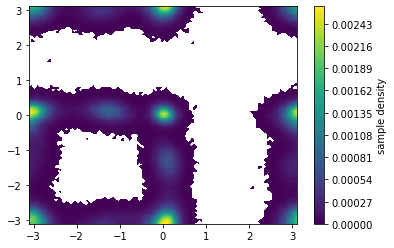

In [59]:
pyemma.plots.plot_density(*pc_data.T)

## Perform PCA

In [60]:
pca = pyemma.coordinates.pca(data, dim=8)
pca_output = pca.get_output()

calc mean+cov:   0%|                                                                                          …

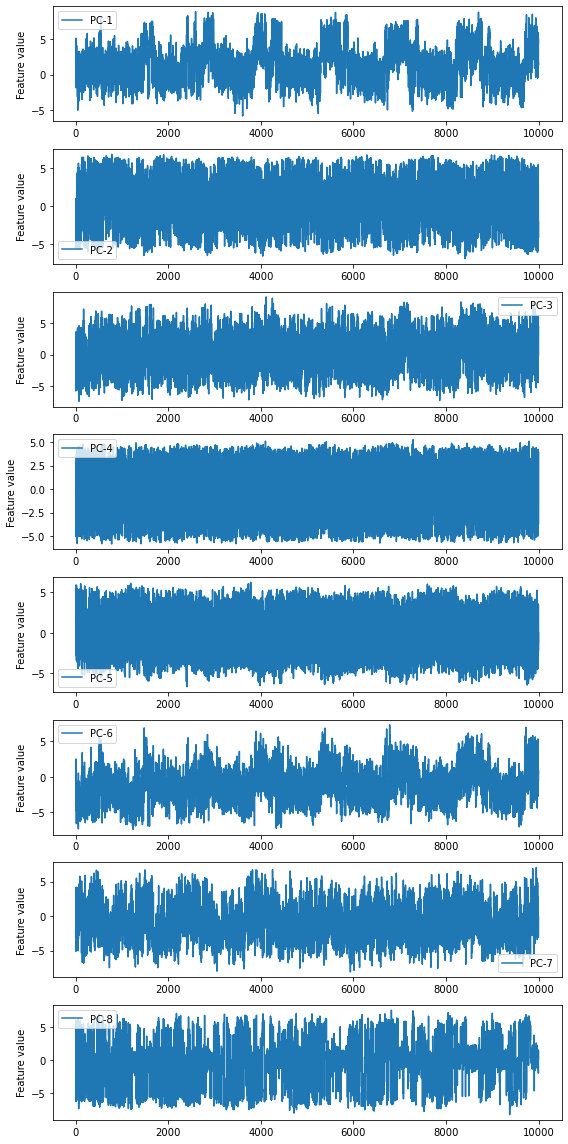

In [66]:
dim = 8
fig, axes = plt.subplots(dim,1,figsize=(dim,dim*2))
for ic in range(0,dim):
    ax = axes[ic]
    ax.plot(pca_output[0][:10000,ic], label='PC-'+str(ic+1))
    ax.set_ylabel('Feature value')
    ax.legend()
    fig.tight_layout()

## Find correlations with data

In [69]:
from scipy.stats import pearsonr
PCA_feature_correlation = np.zeros((data.shape[1], dim))

for i in range(data.shape[1]):
    for j in range(dim):
        PCA_feature_correlation[i, j] = np.abs(pearsonr(data[:, i],pca_output[0][:, j])[0])

Text(0.5, 1.0, 'Pearson correlation coefficient')

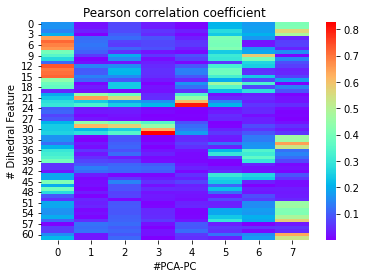

In [71]:
sns.heatmap(PCA_feature_correlation, cmap='rainbow')
plt.xlabel('#PCA-PC')
plt.ylabel('# Dihedral Feature')
plt.title('Pearson correlation coefficient')

In [78]:
np.where(PCA_feature_correlation[:,0]>0.6)[0]+3

array([ 7,  8,  9, 10, 15, 16, 17, 18])

## Find correlations with VAMPNet-ReLU data

In [79]:
from scipy.stats import pearsonr
cross_feature_correlation = np.zeros((output_size,output_size))

for i in range(output_size):
    for j in range(output_size):
        cross_feature_correlation[i, j] = np.abs(pearsonr(pca_output[0][:,i], vnet_features[:, j])[0])

Text(0.5, 1.0, 'Pearson correlation coefficient')

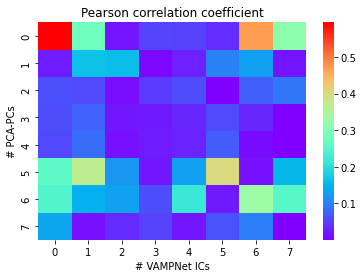

In [81]:
sns.heatmap(cross_feature_correlation, cmap='rainbow')
plt.xlabel('# VAMPNet ICs')
plt.ylabel('# PCA-PCs')
plt.title('Pearson correlation coefficient')

## Find correlations with VAMPNet-Softmax data

In [97]:
from scipy.stats import pearsonr
cross_feature_correlation = np.zeros((output_size,output_size))

for i in range(output_size):
    for j in range(output_size):
        cross_feature_correlation[i, j] = np.abs(pearsonr(pca_output[0][:,i], state_probabilities[:, j])[0])

Text(0.5, 1.0, 'Pearson correlation coefficient')

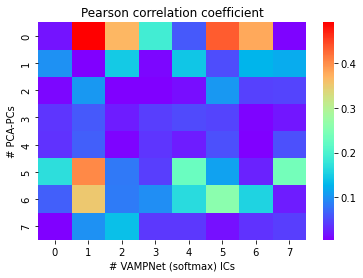

In [98]:
sns.heatmap(cross_feature_correlation, cmap='rainbow')
plt.xlabel('# VAMPNet (softmax) ICs')
plt.ylabel('# PCA-PCs')
plt.title('Pearson correlation coefficient')